In [1]:
%matplotlib inline

In [2]:
import datetime
import pandas as pd
import numpy as np
import datetime

In [3]:
import catboost
from catboost import CatBoostClassifier, Pool, cv
import hyperopt

In [4]:
import tqdm

In [5]:
from sklearn.pipeline import Pipeline
import sklearn.model_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import model_selection , metrics   #Additional scklearn functions

## import and parameters

In [6]:
imput_strategy = 1

In [7]:
train = pd.read_pickle('../data/merged_data/train.pkl')
test = pd.read_pickle('../data/merged_data/test.pkl')

In [8]:
#train = train.sample(frac=0.1)

In [9]:
# preprocess
y_train = train['target'].values

# to try:
* optimize aucroc with keras and batch methods
* SVM / rank SVM (https://github.com/rdipietro/pyrvm)
* try separate models on separate variables + stacking

## Features : 
* NLP on COMMENTAIRE_BI
* Extract options from OPTION (pas sur que ce soit util, peut être juste check la qualité)
* features from history



* check for intervention in test without contracts and to handle them
* add combinations of categorical features (see paribas example on catboost site)
* select only best features (feature_importance ?)
* try to put random nas in train for handling missing contracts

## Fails:
* one model with selectKbest on modalities vs one model on dimensionality reduction with group rare modalities
    * dimensionality reduction don't bring much value here (mb MCA)
    * select k best fails with 5k categories, which is not enough to be interesting

In [10]:
drop = ['INSTANCE_ID', #460k modalities, not usable as a feature
        'INCIDENT_NUMBER']
drop_atm = [#'AUTEUR_INCIDENT', # 2088 modalities
            'TYPE_VOIE',
#            'NATURE_CODE', # 313 modalities, need to be splitted in 5 modalities
#            'MARQUE_LIB', # 167 modalities
#            'OPTION', # 80 modalities, extract options
#            'MODELE_CODE', # 10k modalities
#            'COMMENTAIRE_BI', # NLP 400k modalities
#             'RESOURCE_ID', # 4033 modalities
            'CODE_POSTAL', # 5800 modalities (only get first 2 numbers ?)
            'L2_ORGA_CODE_POSTAL', # 147 modalities (might be redondent with L2_ORGANISATION_ID)
#            'L2_ORGANISATION_ID' #151 modalities
            'L2_ORGA_VILLE', # 146, might be redondent with other organisation variables
#            'RACHAT_CODE' # 312 modalities (try binarising ?)         
#            'CODE_INSTALLATION' # 17 modalities
           ]

In [11]:
train.drop(drop + drop_atm + ['target'], axis=1, inplace=True)
test.drop(drop + drop_atm, axis=1, inplace=True)

### imputation of missing data

TODO: try imputing test based on test values, not train <br>
TODO: try diffrent strategy on imputing datas from contract since missing are present only in test set<BR>
TODO: try creating data with missing contract in train sample and do not fill the missing in test<br>
TODO: try imputing specific na value for categorical variables

In [12]:
def impute_selected_variables(df, test, categ, quanti, dates):
    _df = df.copy()
    _test = test.copy() if test is not None else None
    
    replace = _df[categ].mode()
    replace_values = {k:v.iloc[0] for k,v in replace.items()}
    _df.fillna(replace_values, inplace=True)

    replace_quanti = _df[quanti].mean()
    _df.fillna(replace_quanti, inplace=True)

    _df[dates] = _df[dates].fillna(method='pad')
    
    if test is not None:
        
        _test.fillna(replace_values, inplace=True)
        _test.fillna(replace_quanti, inplace=True)
        _test[dates] = _df[dates].fillna(method='pad')
    
    return _df, _test

In [13]:
#replace = train[categoricals].mode()
#replace_values = {k:v.iloc[0] for k,v in replace.items()}
def impute_contract_variables(df):
    df_ = df.copy()
    
    for var in categ_contract:
        _df[var] = _df[var].cat.add_categories(['NAN'])
        _df[var].fillna('NAN', inplace=True)

    _df[quanti_contract].fillna(-999, inplace=True)
    _df[date_contract].fillna(datetime.datetime(1970, 1, 1), inplace=True)
    return _df

In [14]:
categoricals = list(train.columns[train.dtypes == 'category'])
quantitative = ['NB_PASSAGE', 'POINTS_FIDEL', 'CONTRAT_TARIF', 'PRIX_FACTURE']
dates = list(train.columns[train.dtypes == 'datetime64[ns]'])

In [15]:
contract_variables = [ 'UPD_DATE', 'DATE_DEBUT', 'DATE_FIN', 'STS_CODE', 'OPTION', 'FORMULE', 'CONTRAT_TARIF', 'PRIX_FACTURE']

In [16]:
#impute without contract
categ_to_impute = list(set(categoricals) - set(contract_variables))
quanti_to_impute = list(set(quantitative) - set(contract_variables))
date_to_impute = list(set(dates) - set(contract_variables))

In [17]:
#impute contract
categ_contract = list(set(categoricals).intersection(set(contract_variables)))
quanti_contract = list(set(quantitative).intersection(set(contract_variables)))
date_contract = list(set(dates).intersection(set(contract_variables)))

In [18]:
#train and test are filled with values taken from train
#contract and other variables are imputed together
if imput_strategy == 1:
    train, test = impute_selected_variables(train, test, categoricals, quantitative, dates)

In [19]:
#train and test are filled with values taken on their own values
#contract and other variables are imputed together
if imput_strategy == 2:
    train, _ = impute_selected_variables(train, None, categoricals, quantitative, dates)
    test, _ = impute_selected_variables(test, None, categoricals, quantitative, dates)

In [20]:
#train and test are filled with values taken from train
#contract and other variables are imputed separatly
if imput_strategy == 3:
    train, test = impute_selected_variables(train, test, categ_to_impute, quanti_to_impute, date_to_impute)
    train = impute_contract_variables(train)
    test = impute_contract_variables(test)

In [21]:
#train and test are filled on their own values
#contract and other variables are imputed separatly
if imput_strategy == 4:
    train, _ = impute_selected_variables(train, None, categ_to_impute, quanti_to_impute, date_to_impute)
    test, _ = impute_selected_variables(test, None, categ_to_impute, quanti_to_impute, date_to_impute)
    train = impute_contract_variables(train)
    test = impute_contract_variables(test)

### Feature ingineering

In [22]:
def commentaire_bi(df):
    _df = df.copy()
    
    _df.COMMENTAIRE_BI = _df.COMMENTAIRE_BI.str.upper()
    COMMENTAIRE_BI_vc = _df.COMMENTAIRE_BI.value_counts()
    common_commentaire_bi = COMMENTAIRE_BI_vc[COMMENTAIRE_BI_vc > 100].index
    _df['COMMENTAIRE_BI_common'] = _df.COMMENTAIRE_BI.where(_df.COMMENTAIRE_BI.isin(common_commentaire_bi), "Rare")
    
    _df['nb_char_commentaire'] = [len(txt) for txt in _df.COMMENTAIRE_BI]
    _df['nb_mots_commentaire'] = [len(txt.split()) for txt in _df.COMMENTAIRE_BI]
    _df['has_number_commentaire'] = [any(char.isdigit() for char in txt) for txt in _df.COMMENTAIRE_BI]
    _df['is_empty_commentaire'] = [(txt == '.') for txt in _df.COMMENTAIRE_BI]
    _df.drop('COMMENTAIRE_BI', axis=1, inplace=True)
    
    return _df

In [23]:
def nature_code_split(df):
    _df = df.copy()
    nature_code_splitted = [nc.split('-') for nc in df.NATURE_CODE]
    nature_code_df = pd.DataFrame(nature_code_splitted, columns=['nc_1', 'nc_2', 'nc_3', 'nc_4', 'nc_5'])
    nature_code_df.fillna('-1', inplace=True)
    for nc_i in ['nc_1', 'nc_2', 'nc_3', 'nc_4', 'nc_5']:
        nature_code_df[nc_i] = nature_code_df[nc_i].astype('category')
    
    #_df.drop('NATURE_CODE', axis=1, inplace=True)
    _df = _df.merge(nature_code_df, left_index=True, right_index=True)
    return _df

In [24]:
# todo: use dt series accessor
def add_dates_features(data):
    data['age_installation'] = (data['CRE_DATE_GZL'] - data['INSTALL_DATE']).dt.days // 365
    data['mois_appel'] = data['CRE_DATE_GZL'].map(lambda x: x.month)
    data['joursemaine_appel'] = data['CRE_DATE_GZL'].map(lambda x: x.isoweekday()) #integer, might be considered categorical
    data['jour_appel'] = data['CRE_DATE_GZL'].map(lambda x: x.day)
    data['mois_intervention'] = data['SCHEDULED_START_DATE'].map(lambda x: x.month)
    data['joursemaine_intervention'] = data['SCHEDULED_START_DATE'].map(lambda x: x.isoweekday()) #integer, might be considered categorical
    data['jour_intervention'] = data['SCHEDULED_START_DATE'].map(lambda x: x.day)
    data['duree_avant_intervention'] = (data['SCHEDULED_START_DATE'] - data['CRE_DATE_GZL']).dt.days
    data['duree_prevue'] = (data['SCHEDULED_END_DATE'] - data['SCHEDULED_START_DATE']).dt.days
    data['temps_depuis_debut_contrat'] = (data['CRE_DATE_GZL'] - data['DATE_DEBUT']).dt.days
    data['temps_jusqua_fin_contrat'] = (data['CRE_DATE_GZL'] - data['DATE_FIN']).dt.days  #souvent nan ? (mettre 0)
    data['temps_depuis_maj_contrat'] = (data['CRE_DATE_GZL'] - data['UPD_DATE']).dt.days 

    data.drop(['CRE_DATE_GZL', 'INSTALL_DATE', 'SCHEDULED_START_DATE', 'SCHEDULED_END_DATE', 'DATE_DEBUT', 'DATE_FIN', 'UPD_DATE'], axis=1, inplace=True)
    return data

In [25]:
#mots en particulier
#créer un dictionnaire et compter (count et garder les must ? voir la diff entre les cas + et - ?)

In [26]:
# feature engineering

# (history) temps depuis dernière visite (pas forcément dispo sur le test)
# (history) déjà eu une casse sur ce matériel
# (history) temps depuis dernière casse
# (history) la dernière visite date de moins de 6 mois
# (history) nb interventions faires par la ressource
# (history) temps depuis la première intervention de la ressource
# (contract history) nb de fois que le contrat a été mis à jour sur les X dernières années

In [27]:
train = commentaire_bi(train)
train = nature_code_split(train)
train = add_dates_features(train)

In [28]:
test = commentaire_bi(test)
test = nature_code_split(test)
test = add_dates_features(test)

In [29]:
#drop variables
drop = ['joursemaine_appel', 
'USAGE_LOCAL', 
'nc_4', 
'is_empty_commentaire', 
'duree_prevue', 
'nc_1']

train.drop(drop, axis=1,inplace=True)
test.drop(drop, axis=1,inplace=True)

# Modelisation

TODO:
* one hot encoding low modalities: keep for grid search (no ideal value found right now, try 3, 5, ... 9)
* group rare modalities: doesn't seem to improve the model

### split train / val

In [23]:
#for item in categoricals:
#    train[item] = train[item].cat.codes +1

In [24]:
# split train in train, cv (will be replaced by cross validation for parameters tuning)
# stratify ?
X_train_train, X_train_val, y_train_train, y_train_val = sklearn.model_selection.train_test_split(train, y_train, random_state=101)

In [26]:
pos_neg_ratio =  sum(y_train==0) / sum(y_train)

In [28]:
#combinations_ctr for list of variables ?
model = CatBoostClassifier(
    iterations=200,
#    one_hot_max_size=3,
#    learning_rate=0.16,
    depth=8,
    eval_metric="AUC",
    random_seed=42,
    od_type='Iter',
    od_wait=40,
    use_best_model=True
#    scale_pos_weight=pos_neg_ratio
)

In [29]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [X_train_train.columns.get_loc(cat) for cat in categoricals]

In [30]:
model.fit(
    X_train_train, y_train_train,
    cat_features=categorical_features_indices,
    eval_set=(X_train_val, y_train_val),
    logging_level='Verbose'  # you can uncomment this for text output
)

Learning rate set to 0.312918
0:	test: 0.6998147	best: 0.6998147 (0)	total: 4.74s	remaining: 15m 43s
1:	test: 0.7093075	best: 0.7093075 (1)	total: 9.51s	remaining: 15m 41s
2:	test: 0.7136381	best: 0.7136381 (2)	total: 14.4s	remaining: 15m 48s
3:	test: 0.7161682	best: 0.7161682 (3)	total: 19.1s	remaining: 15m 33s
4:	test: 0.7241421	best: 0.7241421 (4)	total: 24.4s	remaining: 15m 52s
5:	test: 0.7277995	best: 0.7277995 (5)	total: 30.6s	remaining: 16m 29s
6:	test: 0.7292006	best: 0.7292006 (6)	total: 36.2s	remaining: 16m 37s
7:	test: 0.7293384	best: 0.7293384 (7)	total: 41.5s	remaining: 16m 36s
8:	test: 0.7321992	best: 0.7321992 (8)	total: 47.9s	remaining: 16m 56s
9:	test: 0.7324205	best: 0.7324205 (9)	total: 53.3s	remaining: 16m 52s
10:	test: 0.7366587	best: 0.7366587 (10)	total: 58.7s	remaining: 16m 49s
11:	test: 0.7389512	best: 0.7389512 (11)	total: 1m 5s	remaining: 17m 6s
12:	test: 0.7433079	best: 0.7433079 (12)	total: 1m 11s	remaining: 17m 10s
13:	test: 0.7448536	best: 0.7448536 (13)	

111:	test: 0.7667670	best: 0.7667862 (107)	total: 12m 47s	remaining: 10m 2s
112:	test: 0.7667685	best: 0.7667862 (107)	total: 12m 53s	remaining: 9m 55s
113:	test: 0.7667690	best: 0.7667862 (107)	total: 12m 59s	remaining: 9m 48s
114:	test: 0.7667607	best: 0.7667862 (107)	total: 13m 5s	remaining: 9m 40s
115:	test: 0.7667589	best: 0.7667862 (107)	total: 13m 11s	remaining: 9m 33s
116:	test: 0.7670066	best: 0.7670066 (116)	total: 13m 17s	remaining: 9m 25s
117:	test: 0.7670075	best: 0.7670075 (117)	total: 13m 24s	remaining: 9m 18s
118:	test: 0.7670005	best: 0.7670075 (117)	total: 13m 29s	remaining: 9m 11s
119:	test: 0.7670151	best: 0.7670151 (119)	total: 13m 34s	remaining: 9m 2s
120:	test: 0.7670786	best: 0.7670786 (120)	total: 13m 40s	remaining: 8m 55s
121:	test: 0.7671223	best: 0.7671223 (121)	total: 13m 46s	remaining: 8m 48s
122:	test: 0.7671418	best: 0.7671418 (122)	total: 13m 51s	remaining: 8m 40s
123:	test: 0.7671522	best: 0.7671522 (123)	total: 13m 58s	remaining: 8m 33s
124:	test: 0.7

199:	test: 0.7686368	best: 0.7686409 (198)	total: 14m 41s	remaining: 0us (nlp, lr=0.31)
199:	test: 0.7686109	best: 0.7686109 (199)	total: 14m 17s	remaining: 0us (nlp, lr=0.31, 9 variables dropped)
199:	test: 0.7729298	best: 0.7730353 (190)	total: 22m 13s	remaining: 0us (nlp, lr=0.31, 6 variables dropped, depth=8)
199:	test: 0.7576144	best: 0.7576257 (197)	total: 15m 42s	remaining: 0us(nlp, lr=0.31, weighted, one_hot=3)

### Feature importance

In [138]:
importances=model.feature_importances_

In [143]:
indices = np.argsort(model.feature_importances_)[::-1]

print("Feature ranking:")

for f in range(train.shape[1]):
    print("%d. %s (%f)" % (f + 1, train.columns[indices[f]], model.feature_importances_[indices[f]]))

Feature ranking:
1. RESOURCE_ID (27.207315)
2. INCIDENT_TYPE_ID (10.336058)
3. MODELE_CODE (8.156044)
4. L2_ORGANISATION_ID (6.504438)
5. COMMENTAIRE_BI_common (4.962030)
6. nb_char_commentaire (4.617165)
7. mois_intervention (3.927007)
8. GRAVITE (3.428271)
9. duree_avant_intervention (3.302414)
10. FORMULE (2.948463)
11. TYPE_BI (2.159771)
12. MILLESIME (2.098388)
13. PRIX_FACTURE (1.477682)
14. STS_CODE (1.384772)
15. STOP_PHONING (1.343261)
16. age_installation (1.334129)
17. MARQUE_LIB (1.186078)
18. ORIGINE_INCIDENT (1.149478)
19. temps_jusqua_fin_contrat (1.136788)
20. NATURE_CODE (1.045200)
21. CODE_FONCTION (1.039710)
22. AUTEUR_INCIDENT (1.012526)
23. nb_mots_commentaire (0.996839)
24. NB_PASSAGE (0.900538)
25. TYPE_OCC (0.691217)
26. mois_appel (0.586437)
27. OPTION (0.528086)
28. joursemaine_intervention (0.462390)
29. CONTRAT_TARIF (0.455775)
30. POINTS_FIDEL (0.423038)
31. L1_ORGANISATION_ID (0.379163)
32. nc_5 (0.346799)
33. temps_depuis_maj_contrat (0.333463)
34. CODE_G

In [137]:
import matplotlib.pyplot as plt

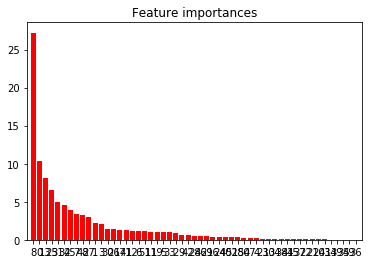

In [140]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()

### Hyperparameter tunning

In [35]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

#### GridSearch

In [31]:
from sklearn.grid_search import GridSearchCV

In [37]:
#what to do with cat features
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.20, 0.31, 0.40],
         'l2_leaf_reg': [1, 4, 9],
         'iterations': [300]}
cb = CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc")
cb_model.fit(train, y_train, cb__cat_features=categorical_features_indices)

TypeError: fit() got an unexpected keyword argument 'cb__cat_features'

#### hyperopt

In [38]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=int(params['iterations']),
        border_count=int(params['border_count']),
        eval_metric='AUC',
        random_seed=42,
        logging_level='Silent'
        #od_type='Iter',
        #od_wait=40
    )
    
    cv_data = cv(
        Pool(train, y_train, cat_features=categorical_features_indices),
        model.get_params(),
        fold_count=3
    )
    best_AUC = np.max(cv_data['test-AUC-mean'])
    print(params, 'best_AUC: ', best_AUC)
    
    return 1 - best_AUC # as hyperopt minimises

In [39]:
#param space example for xgboost
#    space = {
#             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
#             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
#             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
#             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
#             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
#             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
#             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#             'num_class' : 9,
#             'eval_metric': 'mlogloss',
#             'objective': 'multi:softprob',
#             'nthread' : 6,
#             'silent' : 1
#}

In [41]:
from numpy.random import RandomState

params_space = {
    #'l2_leaf_reg': hyperopt.hp.loguniform('l2_leaf_reg', -1, np.log(50)),
    'l2_leaf_reg': hyperopt.hp.choice('l2_leaf_reg', [11.47871028241772]),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-1, 8e-1),
     #'learning_rate': hyperopt.hp.choice('learning_rate', [0.31]),
    'iterations': hyperopt.hp.quniform('iterations', 250, 1000, 1),
    #'iterations': hyperopt.hp.choice('iterations', [250]),
    #'depth': hyperopt.hp.quniform('depth', 3, 9, 1),
    'depth': hyperopt.hp.choice('depth', [7]),
#    'ctr_border_count': hyperopt.hp.quniform('ctr_border_count', 32, 255, 1),
    #'border_count': hyperopt.hp.quniform('border_count', 16, 255, 1)
    'border_count': hyperopt.hp.choice('border_count', [213])
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=8,
    trials=trials,
    rstate=RandomState(123)
    
)

print(best)

{'border_count': 213, 'depth': 7, 'iterations': 693.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.6096210638782021} best_AUC:  0.767539056284941
{'border_count': 213, 'depth': 7, 'iterations': 526.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.701085638831484} best_AUC:  0.767228088670764
{'border_count': 213, 'depth': 7, 'iterations': 822.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.7947626751796161} best_AUC:  0.7647414699770261
{'border_count': 213, 'depth': 7, 'iterations': 775.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.571434077994127} best_AUC:  0.7686875566115616
{'border_count': 213, 'depth': 7, 'iterations': 516.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.4938304425560929} best_AUC:  0.7680238623609622


KeyboardInterrupt: 

#round 1
{'depth': 7.0, 'l2_leaf_reg': 6.687638927479829} best_AUC:  0.764339203919555
{'depth': 8.0, 'l2_leaf_reg': 2.238434810070511} best_AUC:  0.7641940842160905
{'depth': 9.0, 'l2_leaf_reg': 15.61615505112418} best_AUC:  0.7656179177534072
{'depth': 7.0, 'l2_leaf_reg': 11.47871028241772} best_AUC:  0.766724797438951
{'depth': 6.0, 'l2_leaf_reg': 2.0946141383866816} best_AUC:  0.7641940842160905
{'depth': 5.0, 'l2_leaf_reg': 3.409700409045487} best_AUC:  0.7656396435014416
{'l2_leaf_reg': 11.47871028241772, 'learning_rate': 7.0}

#round 2
{'border_count': 199.0, 'depth': 7, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7654693707749893
{'border_count': 213.0, 'depth': 7, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7662068818039395
{'border_count': 105.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7639026943327258
{'border_count': 238.0, 'depth': 7, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.764574925126635
{'border_count': 22.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7643064612539859
{'border_count': 103.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7632638136706521
{'border_count': 225.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7653002122083675
{'border_count': 212.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7649391813119792
{'border_count': 85.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7649657537494025
{'border_count': 251.0, 'depth': 8, 'iterations': 250, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.31} best_AUC:  0.7649243873489558
{'border_count': 213.0, 'depth': 0, 'iterations': 0, 'l2_leaf_reg': 0, 'learning_rate': 0}

#round 3
{'border_count': 213, 'depth': 7, 'iterations': 693.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.6096210638782021} best_AUC:  0.767539056284941
{'border_count': 213, 'depth': 7, 'iterations': 526.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.701085638831484} best_AUC:  0.767228088670764
{'border_count': 213, 'depth': 7, 'iterations': 822.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.7947626751796161} best_AUC:  0.7647414699770261
{'border_count': 213, 'depth': 7, 'iterations': 775.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.571434077994127} best_AUC:  0.7686875566115616
{'border_count': 213, 'depth': 7, 'iterations': 516.0, 'l2_leaf_reg': 11.47871028241772, 'learning_rate': 0.4938304425560929} best_AUC:  0.7680238623609622


In [ ]:
#check quality to expect
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='AUC',
    random_seed=42,
    logging_level='Silent'
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

In [ ]:
print('Precise validation AUC score: {}'.format(np.max(cv_data['test-AUC-mean'])))

### Make submission

In [30]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

In [31]:
params = {'border_count': 213, 
          'depth': 7, 
          'iterations': 500.0, 
          'l2_leaf_reg': 11.47871028241772, 
          'learning_rate': 0.4938304425560929}

In [32]:
model = CatBoostClassifier(
    **params,
    eval_metric="AUC",
    od_type='Iter',
    od_wait=40
)

model.fit(train, y_train, cat_features=categorical_features_indices)

0:	total: 5.78s	remaining: 48m 4s
1:	total: 11.4s	remaining: 47m 15s
2:	total: 16.1s	remaining: 44m 30s
3:	total: 21s	remaining: 43m 27s
4:	total: 27.4s	remaining: 45m 13s
5:	total: 34.3s	remaining: 47m
6:	total: 40.3s	remaining: 47m 16s
7:	total: 46.4s	remaining: 47m 35s
8:	total: 51.4s	remaining: 46m 43s
9:	total: 58.2s	remaining: 47m 30s
10:	total: 1m 3s	remaining: 47m 3s
11:	total: 1m 9s	remaining: 47m 3s
12:	total: 1m 14s	remaining: 46m 43s
13:	total: 1m 21s	remaining: 47m 20s
14:	total: 1m 27s	remaining: 47m 12s
15:	total: 1m 33s	remaining: 47m 2s
16:	total: 1m 40s	remaining: 47m 21s
17:	total: 1m 47s	remaining: 48m 1s
18:	total: 1m 53s	remaining: 47m 50s
19:	total: 1m 58s	remaining: 47m 15s
20:	total: 2m 4s	remaining: 47m 15s
21:	total: 2m 12s	remaining: 47m 49s
22:	total: 2m 17s	remaining: 47m 37s
23:	total: 2m 23s	remaining: 47m 30s
24:	total: 2m 29s	remaining: 47m 21s
25:	total: 2m 36s	remaining: 47m 41s
26:	total: 2m 42s	remaining: 47m 29s
27:	total: 2m 50s	remaining: 47m 56

219:	total: 22m 26s	remaining: 28m 33s
220:	total: 22m 32s	remaining: 28m 27s
221:	total: 22m 38s	remaining: 28m 21s
222:	total: 22m 45s	remaining: 28m 16s
223:	total: 22m 53s	remaining: 28m 12s
224:	total: 23m	remaining: 28m 7s
225:	total: 23m 7s	remaining: 28m 1s
226:	total: 23m 13s	remaining: 27m 55s
227:	total: 23m 20s	remaining: 27m 50s
228:	total: 23m 27s	remaining: 27m 45s
229:	total: 23m 33s	remaining: 27m 38s
230:	total: 23m 39s	remaining: 27m 33s
231:	total: 23m 46s	remaining: 27m 28s
232:	total: 23m 55s	remaining: 27m 24s
233:	total: 24m 1s	remaining: 27m 18s
234:	total: 24m 8s	remaining: 27m 13s
235:	total: 24m 15s	remaining: 27m 7s
236:	total: 24m 22s	remaining: 27m 3s
237:	total: 24m 31s	remaining: 26m 59s
238:	total: 24m 37s	remaining: 26m 53s
239:	total: 24m 44s	remaining: 26m 48s
240:	total: 24m 51s	remaining: 26m 43s
241:	total: 24m 58s	remaining: 26m 37s
242:	total: 25m 5s	remaining: 26m 31s
243:	total: 25m 11s	remaining: 26m 26s
244:	total: 25m 18s	remaining: 26m 20

432:	total: 44m 21s	remaining: 6m 51s
433:	total: 44m 28s	remaining: 6m 45s
434:	total: 44m 33s	remaining: 6m 39s
435:	total: 44m 39s	remaining: 6m 33s
436:	total: 44m 45s	remaining: 6m 27s
437:	total: 44m 51s	remaining: 6m 20s
438:	total: 44m 56s	remaining: 6m 14s
439:	total: 45m 3s	remaining: 6m 8s
440:	total: 45m 11s	remaining: 6m 2s
441:	total: 45m 17s	remaining: 5m 56s
442:	total: 45m 24s	remaining: 5m 50s
443:	total: 45m 30s	remaining: 5m 44s
444:	total: 45m 36s	remaining: 5m 38s
445:	total: 45m 42s	remaining: 5m 32s
446:	total: 45m 49s	remaining: 5m 25s
447:	total: 45m 56s	remaining: 5m 19s
448:	total: 46m 2s	remaining: 5m 13s
449:	total: 46m 9s	remaining: 5m 7s
450:	total: 46m 16s	remaining: 5m 1s
451:	total: 46m 23s	remaining: 4m 55s
452:	total: 46m 30s	remaining: 4m 49s
453:	total: 46m 37s	remaining: 4m 43s
454:	total: 46m 43s	remaining: 4m 37s
455:	total: 46m 50s	remaining: 4m 31s
456:	total: 46m 56s	remaining: 4m 25s
457:	total: 47m 2s	remaining: 4m 18s
458:	total: 47m 9s	r

In [37]:
#save model to disk
model.save_model('catboost_model.dump')
#load
#model = CatBoostClassifier()
#model.load_model('catboost_model.dump');

In [35]:
submisstion = model.predict_proba(test)[:, 1]

In [36]:
filename = str(datetime.datetime.now())[:-7] + '_submission.csv'
sub = pd.Series(submisstion, name='target')
sub.to_csv(filename, index=False, header=True)

### train with some randomly added na for contract variables

In [ ]:
models = []

#np.random.seed(42)
for i in tqdm.tqdm_notebook(range(100)):
    X_train = train.copy()
    
    #randomly put missing contract in train data
    _idx = np.random.choice(X_train.index, size=X_train.shape[0]//20, replace=False)
    X_train.loc[_idx, categ_to_impute].fillna('NAN', inplace=True)
    X_train.loc[_idx, quanti_contract].fillna(-999, inplace=True)
    X_train.loc[_idx, date_contract].fillna(datetime.datetime(1970, 1, 1), inplace=True)

    model = CatBoostClassifier(
        iterations=1000,
        depth=6,
        thread_count=12,
        border_count=128,
        learning_rate=0.015,
        random_seed=np.random.randint(10**10),
        logging_level='Silent'
    )
    
    model.fit(X_train, y)
    models.append(model.copy())

In [ ]:
predictions = []
for _model in tqdm.tqdm_notebook(models):
    predictions.append(_model.predict_proba(X_test)[:,1])
    
predictions = np.vstack(predictions).T.mean(axis=1)

In [ ]:
#prediction = np.hstack([predictions, predictions2]).mean(axis=1)

### XGBoost and lightGBM

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [ ]:
%%time
param_grid1 = {'max_depth':[10],
               'min_child_weight':[2]}

model_xgb = XGBClassifier(learning_rate =0.1, 
                      n_estimators=200, 
                      max_depth=10,
                      min_child_weight=1, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=7, 
                      scale_pos_weight=1, 
                      eval_metric='auc',
                      seed=29)

In [ ]:
model_xgb.fit(X_train_train, y_train_train, eval_set=[(X_train_val, y_train_val)])

In [ ]:
import lightgbm

In [ ]:
model_gbm = lightgbm.LGBMClassifier(
    seed=np.random.randint(10**10),
    n_estimators=500,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary'
)

In [ ]:
model_gbm.fit(X_train_train, y_train_train, 
              eval_set=[(X_train_val, y_train_val)], 
              eval_metric='auc', 
              categorical_feature=categorical_features_indices)